Using device: cuda
Attempting to load local MNIST dataset...
Successfully loaded local dataset: 60000 training samples
Dataset loaded: 60000 training samples
Networks initialized
Generator parameters: 1489936
Discriminator parameters: 566273
Starting training...
Epoch [1/50] Batch [0/938] D_loss: 1.3909 G_loss: 0.6948 D_real_acc: 0.0625 D_fake_acc: 0.7031
Epoch [1/50] Batch [100/938] D_loss: 1.3034 G_loss: 1.5162 D_real_acc: 0.9375 D_fake_acc: 0.2344
Epoch [1/50] Batch [200/938] D_loss: 1.3624 G_loss: 0.6943 D_real_acc: 0.8906 D_fake_acc: 0.1875
Epoch [1/50] Batch [300/938] D_loss: 1.2927 G_loss: 0.9466 D_real_acc: 0.6875 D_fake_acc: 0.5469
Epoch [1/50] Batch [400/938] D_loss: 1.2621 G_loss: 0.6946 D_real_acc: 0.4062 D_fake_acc: 0.9688
Epoch [1/50] Batch [500/938] D_loss: 1.1523 G_loss: 1.1426 D_real_acc: 0.7656 D_fake_acc: 0.7031
Epoch [1/50] Batch [600/938] D_loss: 1.1763 G_loss: 1.0997 D_real_acc: 0.6875 D_fake_acc: 0.6875
Epoch [1/50] Batch [700/938] D_loss: 1.1885 G_loss: 1.4891 D

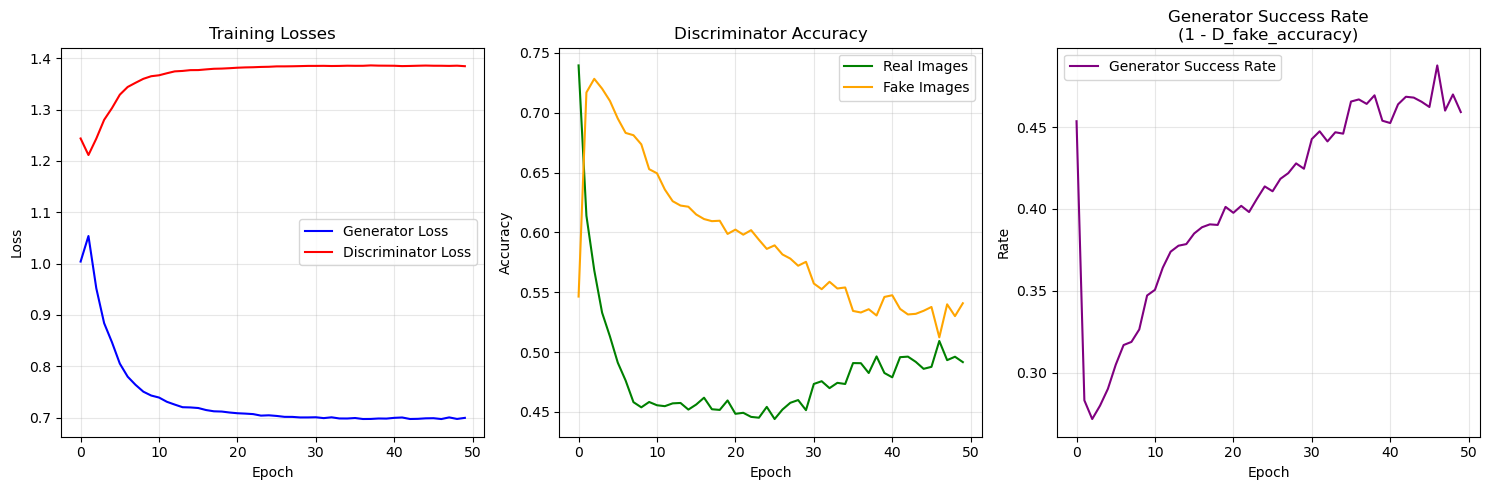

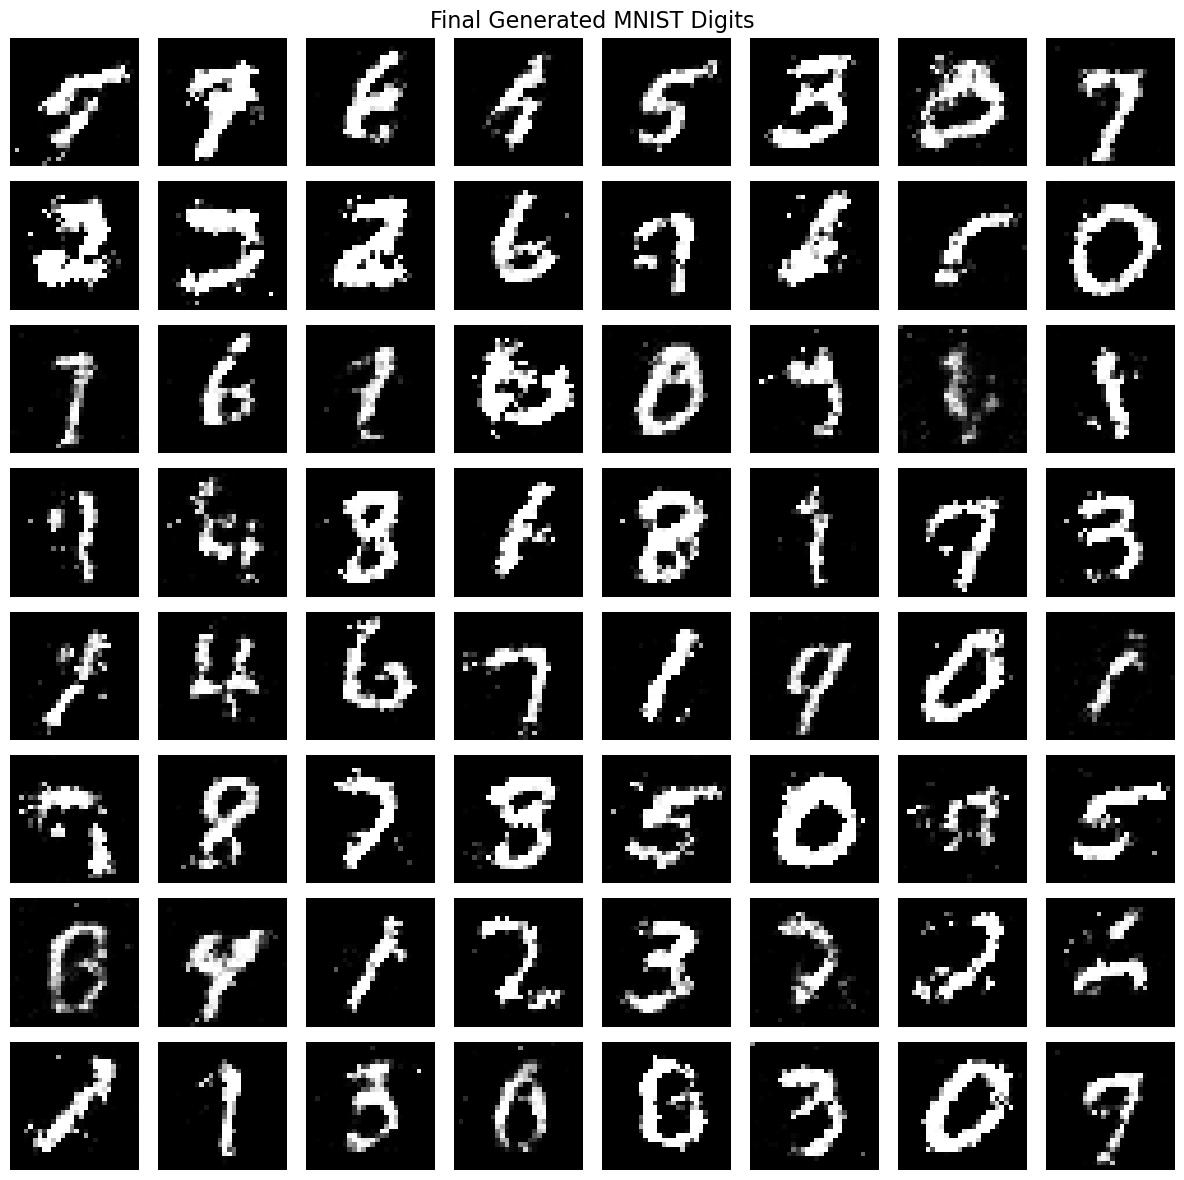


TRAINING ANALYSIS

Final Losses:
Generator Loss: 0.6993
Discriminator Loss: 1.3845

Final Accuracies:
Discriminator on Real Images: 0.4916
Discriminator on Fake Images: 0.5408
Generator Success Rate: 0.4592

Training Stability Metrics:
Generator Loss Variance (last 10 epochs): 0.000001
Discriminator Loss Variance (last 10 epochs): 0.000000

Mode Collapse Indicators:
Discriminator accuracy on fake images should be around 0.5 for balanced training
Current D_fake accuracy: 0.5408
✅ Training appears balanced

Network Architecture Summary:
Generator: 100 → 256 → 512 → 1024 → 784
Discriminator: 784 → 512 → 256 → 128 → 1

Models and training history saved!
Generated images saved in 'generated_images/' directory
Training curves saved as 'training_curves.png'
Final results saved as 'final_generated_digits.png'

ADDITIONAL ANALYSES

Diversity Analysis:
Average pixel variance across generated samples: 0.072258


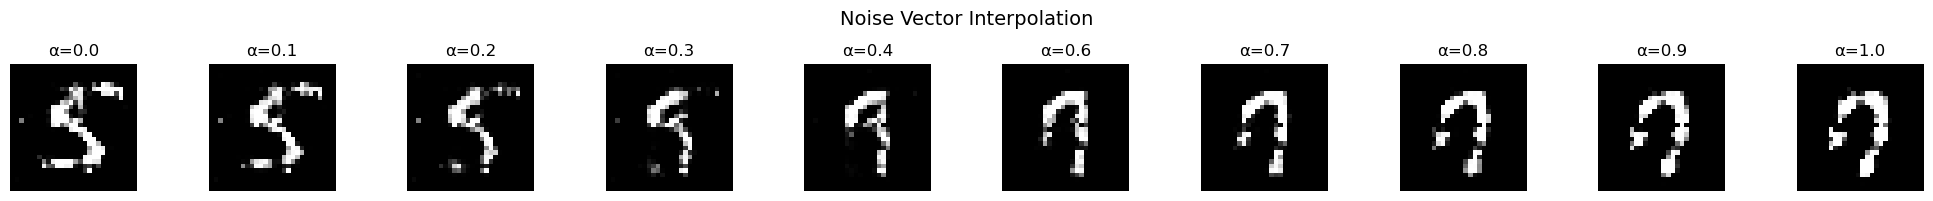


EXERCISE COMPLETE


In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os
from collections import defaultdict

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Hyperparameters
BATCH_SIZE = 64
LEARNING_RATE = 0.0002
NOISE_DIM = 100
NUM_EPOCHS = 50
BETA1 = 0.5  # Beta1 for Adam optimizer

# Create directory for saving images
os.makedirs('generated_images', exist_ok=True)

# Data preprocessing and loading
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # Normalize to [-1, 1]
])

# Load MNIST dataset from local files
# First, let's try to use the local data without downloading
try:
    print("Attempting to load local MNIST dataset...")
    train_dataset = datasets.MNIST(root='./data', train=True, download=False, transform=transform)
    print(f"Successfully loaded local dataset: {len(train_dataset)} training samples")
except:
    print("Local dataset not found in expected format. Checking file structure...")
    
    # Check if the raw files exist
    import os
    data_files = [
        './data/train-images.idx3-ubyte',
        './data/train-labels.idx1-ubyte',
        './data/t10k-images.idx3-ubyte',
        './data/t10k-labels.idx1-ubyte'
    ]
    
    files_exist = all(os.path.exists(f) for f in data_files)
    
    if files_exist:
        print("Raw MNIST files found! Creating dataset structure...")
        
        # Create the proper directory structure for torchvision
        processed_dir = './data/MNIST/processed'
        raw_dir = './data/MNIST/raw'
        os.makedirs(processed_dir, exist_ok=True)
        os.makedirs(raw_dir, exist_ok=True)
        
        # Copy files to expected locations if they don't exist
        import shutil
        file_mapping = {
            './data/train-images.idx3-ubyte': './data/MNIST/raw/train-images-idx3-ubyte',
            './data/train-labels.idx1-ubyte': './data/MNIST/raw/train-labels-idx1-ubyte',
            './data/t10k-images.idx3-ubyte': './data/MNIST/raw/t10k-images-idx3-ubyte',
            './data/t10k-labels.idx1-ubyte': './data/MNIST/raw/t10k-labels-idx1-ubyte'
        }
        
        for src, dst in file_mapping.items():
            if os.path.exists(src) and not os.path.exists(dst):
                shutil.copy2(src, dst)
                print(f"Copied {src} to {dst}")
        
        # Now try loading again
        try:
            train_dataset = datasets.MNIST(root='./data', train=True, download=False, transform=transform)
            print(f"Successfully loaded restructured local dataset: {len(train_dataset)} training samples")
        except:
            print("Still having issues with local files. Using alternative loading method...")
            
            # Alternative: Custom dataset loader for your file structure
            class LocalMNIST(torch.utils.data.Dataset):
                def __init__(self, images_file, labels_file, transform=None):
                    import struct
                    
                    # Load images
                    with open(images_file, 'rb') as f:
                        magic, num_images, rows, cols = struct.unpack('>IIII', f.read(16))
                        images = np.frombuffer(f.read(), dtype=np.uint8)
                        images = images.reshape(num_images, rows, cols)
                    
                    # Load labels
                    with open(labels_file, 'rb') as f:
                        magic, num_labels = struct.unpack('>II', f.read(8))
                        labels = np.frombuffer(f.read(), dtype=np.uint8)
                    
                    self.images = images
                    self.labels = labels
                    self.transform = transform
                
                def __len__(self):
                    return len(self.images)
                
                def __getitem__(self, idx):
                    image = self.images[idx]
                    label = self.labels[idx]
                    
                    # Convert to PIL Image for transform compatibility
                    from PIL import Image
                    image = Image.fromarray(image, mode='L')
                    
                    if self.transform:
                        image = self.transform(image)
                    
                    return image, label
            
            # Use custom loader
            print("Using custom dataset loader...")
            train_dataset = LocalMNIST('./data/train-images.idx3-ubyte', './data/train-labels.idx1-ubyte', transform=transform)
            print(f"Custom dataset loaded: {len(train_dataset)} training samples")
    else:
        print("Raw MNIST files not found. Downloading dataset...")
        train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

print(f"Dataset loaded: {len(train_dataset)} training samples")

# Generator Network
class Generator(nn.Module):
    def __init__(self, noise_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            # First layer
            nn.Linear(noise_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(True),
            
            # Second layer
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(True),
            
            # Third layer
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(True),
            
            # Output layer
            nn.Linear(1024, 784),  # 28*28 = 784
            nn.Tanh()  # Output in [-1, 1] to match normalized data
        )
    
    def forward(self, z):
        return self.model(z)

# Discriminator Network
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            # First layer
            nn.Linear(784, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            
            # Second layer
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            
            # Third layer
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            
            # Output layer
            nn.Linear(128, 1),
            nn.Sigmoid()  # Output probability [0, 1]
        )
    
    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        return self.model(x)

# Initialize networks
generator = Generator(NOISE_DIM).to(device)
discriminator = Discriminator().to(device)

# Initialize weights
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

generator.apply(weights_init)
discriminator.apply(weights_init)

print("Networks initialized")
print(f"Generator parameters: {sum(p.numel() for p in generator.parameters())}")
print(f"Discriminator parameters: {sum(p.numel() for p in discriminator.parameters())}")

# Loss function and optimizers
criterion = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=LEARNING_RATE, betas=(BETA1, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=LEARNING_RATE, betas=(BETA1, 0.999))

# Labels for real and fake samples
real_label = 1.0
fake_label = 0.0

# Fixed noise for consistent visualization
fixed_noise = torch.randn(64, NOISE_DIM, device=device)

# Training history
G_losses = []
D_losses = []
D_real_accuracy = []
D_fake_accuracy = []

def save_generated_images(generator, epoch, noise, save_path):
    """Save a grid of generated images"""
    generator.eval()
    with torch.no_grad():
        fake_images = generator(noise).detach().cpu()
        fake_images = fake_images.view(-1, 1, 28, 28)
        fake_images = (fake_images + 1) / 2  # Denormalize from [-1,1] to [0,1]
        
        # Create a grid of images
        fig, axes = plt.subplots(8, 8, figsize=(10, 10))
        fig.suptitle(f'Generated Images - Epoch {epoch}', fontsize=16)
        
        for i in range(64):
            row, col = i // 8, i % 8
            axes[row, col].imshow(fake_images[i, 0], cmap='gray')
            axes[row, col].axis('off')
        
        plt.tight_layout()
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        plt.close()
    generator.train()

def calculate_accuracy(predictions, targets):
    """Calculate accuracy for discriminator predictions"""
    predicted = (predictions > 0.5).float()
    correct = (predicted == targets).float().sum()
    return correct / targets.size(0)

print("Starting training...")

# Training loop
for epoch in range(NUM_EPOCHS):
    epoch_G_loss = 0.0
    epoch_D_loss = 0.0
    epoch_D_real_acc = 0.0
    epoch_D_fake_acc = 0.0
    num_batches = 0
    
    for i, (real_images, _) in enumerate(train_loader):
        batch_size = real_images.size(0)
        real_images = real_images.to(device)
        
        # Create labels
        real_labels = torch.full((batch_size,), real_label, dtype=torch.float, device=device)
        fake_labels = torch.full((batch_size,), fake_label, dtype=torch.float, device=device)
        
        # ============================================
        # Train Discriminator: maximize log(D(x)) + log(1 - D(G(z)))
        # ============================================
        discriminator.zero_grad()
        
        # Train with real images
        real_images_flat = real_images.view(batch_size, -1)
        output_real = discriminator(real_images_flat).view(-1)
        loss_D_real = criterion(output_real, real_labels)
        
        # Train with fake images
        noise = torch.randn(batch_size, NOISE_DIM, device=device)
        fake_images = generator(noise)
        output_fake = discriminator(fake_images.detach()).view(-1)
        loss_D_fake = criterion(output_fake, fake_labels)
        
        # Total discriminator loss
        loss_D = loss_D_real + loss_D_fake
        loss_D.backward()
        optimizer_D.step()
        
        # Calculate discriminator accuracy
        acc_real = calculate_accuracy(output_real, real_labels)
        acc_fake = calculate_accuracy(output_fake, fake_labels)
        
        # ============================================
        # Train Generator: maximize log(D(G(z)))
        # ============================================
        generator.zero_grad()
        
        # Generate fake images and get discriminator's opinion
        output_fake_for_G = discriminator(fake_images).view(-1)
        # Generator wants discriminator to think fake images are real
        loss_G = criterion(output_fake_for_G, real_labels)
        loss_G.backward()
        optimizer_G.step()
        
        # Accumulate losses and accuracies
        epoch_G_loss += loss_G.item()
        epoch_D_loss += loss_D.item()
        epoch_D_real_acc += acc_real.item()
        epoch_D_fake_acc += acc_fake.item()
        num_batches += 1
        
        # Print progress
        if i % 100 == 0:
            print(f'Epoch [{epoch+1}/{NUM_EPOCHS}] Batch [{i}/{len(train_loader)}] '
                  f'D_loss: {loss_D.item():.4f} G_loss: {loss_G.item():.4f} '
                  f'D_real_acc: {acc_real.item():.4f} D_fake_acc: {acc_fake.item():.4f}')
    
    # Calculate average losses and accuracies for the epoch
    avg_G_loss = epoch_G_loss / num_batches
    avg_D_loss = epoch_D_loss / num_batches
    avg_D_real_acc = epoch_D_real_acc / num_batches
    avg_D_fake_acc = epoch_D_fake_acc / num_batches
    
    # Store losses for plotting
    G_losses.append(avg_G_loss)
    D_losses.append(avg_D_loss)
    D_real_accuracy.append(avg_D_real_acc)
    D_fake_accuracy.append(avg_D_fake_acc)
    
    print(f'Epoch [{epoch+1}/{NUM_EPOCHS}] Average - D_loss: {avg_D_loss:.4f} '
          f'G_loss: {avg_G_loss:.4f} D_real_acc: {avg_D_real_acc:.4f} '
          f'D_fake_acc: {avg_D_fake_acc:.4f}')
    
    # Save generated images every 5 epochs
    if (epoch + 1) % 5 == 0 or epoch == 0:
        save_path = f'generated_images/epoch_{epoch+1:02d}.png'
        save_generated_images(generator, epoch+1, fixed_noise, save_path)
        print(f'Generated images saved to {save_path}')

print("Training completed!")

# ============================================
# Plotting Results
# ============================================

# Plot training losses
plt.figure(figsize=(15, 5))

# Loss curves
plt.subplot(1, 3, 1)
plt.plot(G_losses, label='Generator Loss', color='blue')
plt.plot(D_losses, label='Discriminator Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Losses')
plt.legend()
plt.grid(True, alpha=0.3)

# Discriminator accuracy on real images
plt.subplot(1, 3, 2)
plt.plot(D_real_accuracy, label='Real Images', color='green')
plt.plot(D_fake_accuracy, label='Fake Images', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Discriminator Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

# Combined view of discriminator performance
plt.subplot(1, 3, 3)
plt.plot([(1 - acc) for acc in D_fake_accuracy], label='Generator Success Rate', color='purple')
plt.xlabel('Epoch')
plt.ylabel('Rate')
plt.title('Generator Success Rate\n(1 - D_fake_accuracy)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_curves.png', dpi=150, bbox_inches='tight')
plt.show()

# ============================================
# Generate Final Results
# ============================================

# Generate final batch of images
generator.eval()
with torch.no_grad():
    final_noise = torch.randn(64, NOISE_DIM, device=device)
    final_fake_images = generator(final_noise).detach().cpu()
    final_fake_images = final_fake_images.view(-1, 1, 28, 28)
    final_fake_images = (final_fake_images + 1) / 2  # Denormalize

# Display final results
fig, axes = plt.subplots(8, 8, figsize=(12, 12))
fig.suptitle('Final Generated MNIST Digits', fontsize=16)

for i in range(64):
    row, col = i // 8, i % 8
    axes[row, col].imshow(final_fake_images[i, 0], cmap='gray')
    axes[row, col].axis('off')

plt.tight_layout()
plt.savefig('final_generated_digits.png', dpi=150, bbox_inches='tight')
plt.show()

# ============================================
# Analysis and Metrics
# ============================================

print("\n" + "="*60)
print("TRAINING ANALYSIS")
print("="*60)

print(f"\nFinal Losses:")
print(f"Generator Loss: {G_losses[-1]:.4f}")
print(f"Discriminator Loss: {D_losses[-1]:.4f}")

print(f"\nFinal Accuracies:")
print(f"Discriminator on Real Images: {D_real_accuracy[-1]:.4f}")
print(f"Discriminator on Fake Images: {D_fake_accuracy[-1]:.4f}")
print(f"Generator Success Rate: {1 - D_fake_accuracy[-1]:.4f}")

print(f"\nTraining Stability Metrics:")
loss_variance_G = np.var(G_losses[-10:])  # Variance in last 10 epochs
loss_variance_D = np.var(D_losses[-10:])
print(f"Generator Loss Variance (last 10 epochs): {loss_variance_G:.6f}")
print(f"Discriminator Loss Variance (last 10 epochs): {loss_variance_D:.6f}")

# Check for mode collapse indicators
print(f"\nMode Collapse Indicators:")
print(f"Discriminator accuracy on fake images should be around 0.5 for balanced training")
print(f"Current D_fake accuracy: {D_fake_accuracy[-1]:.4f}")
if D_fake_accuracy[-1] < 0.3:
    print("⚠️  Generator may be fooling discriminator too easily")
elif D_fake_accuracy[-1] > 0.7:
    print("⚠️  Discriminator may be too strong, hampering generator learning")
else:
    print("✅ Training appears balanced")

print(f"\nNetwork Architecture Summary:")
print(f"Generator: {NOISE_DIM} → 256 → 512 → 1024 → 784")
print(f"Discriminator: 784 → 512 → 256 → 128 → 1")

# Save training history
training_history = {
    'generator_losses': G_losses,
    'discriminator_losses': D_losses,
    'discriminator_real_accuracy': D_real_accuracy,
    'discriminator_fake_accuracy': D_fake_accuracy
}

torch.save(training_history, 'training_history.pt')
torch.save(generator.state_dict(), 'generator_final.pt')
torch.save(discriminator.state_dict(), 'discriminator_final.pt')

print(f"\nModels and training history saved!")
print(f"Generated images saved in 'generated_images/' directory")
print(f"Training curves saved as 'training_curves.png'")
print(f"Final results saved as 'final_generated_digits.png'")

# ============================================
# Advanced Analysis Functions
# ============================================

def analyze_digit_diversity():
    """Analyze the diversity of generated digits"""
    generator.eval()
    with torch.no_grad():
        # Generate a large batch for analysis
        noise = torch.randn(1000, NOISE_DIM, device=device)
        generated = generator(noise).detach().cpu()
        generated = generated.view(-1, 28, 28)
        generated = (generated + 1) / 2  # Denormalize
        
        # Calculate some basic diversity metrics
        pixel_variance = torch.var(generated, dim=0).mean().item()
        print(f"\nDiversity Analysis:")
        print(f"Average pixel variance across generated samples: {pixel_variance:.6f}")
        
        return generated

def interpolation_analysis():
    """Generate interpolation between two noise vectors"""
    generator.eval()
    with torch.no_grad():
        # Create two random noise vectors
        z1 = torch.randn(1, NOISE_DIM, device=device)
        z2 = torch.randn(1, NOISE_DIM, device=device)
        
        # Create interpolation
        alphas = torch.linspace(0, 1, 10)
        interpolated_images = []
        
        for alpha in alphas:
            z_interp = alpha * z1 + (1 - alpha) * z2
            img = generator(z_interp).detach().cpu()
            img = img.view(28, 28)
            img = (img + 1) / 2  # Denormalize
            interpolated_images.append(img)
        
        # Plot interpolation
        fig, axes = plt.subplots(1, 10, figsize=(20, 2))
        fig.suptitle('Noise Vector Interpolation', fontsize=14)
        
        for i, img in enumerate(interpolated_images):
            axes[i].imshow(img, cmap='gray')
            axes[i].set_title(f'α={alphas[i]:.1f}')
            axes[i].axis('off')
        
        plt.tight_layout()
        plt.savefig('interpolation_analysis.png', dpi=150, bbox_inches='tight')
        plt.show()

# Run additional analyses
print("\n" + "="*60)
print("ADDITIONAL ANALYSES")
print("="*60)

analyze_digit_diversity()
interpolation_analysis()

print("\n" + "="*60)
print("EXERCISE COMPLETE")
print("="*60)